# Customer Churn Prediction
This notebook demonstrates a simple churn prediction pipeline using a public Telco dataset.
It downloads the dataset from a public raw GitHub URL when run locally.

In [10]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join('..')))

from src.data_preprocessing import load_data_from_url, basic_cleaning
from src.model_training import train_logistic_regression, train_random_forest, evaluate_model, save_model
from src.visualization import plot_churn_distribution, plot_feature_importance

In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from src.data_preprocessing import load_data_from_url, basic_cleaning
from src.model_training import train_logistic_regression, train_random_forest, evaluate_model, save_model
from src.visualization import plot_churn_distribution, plot_feature_importance
import os


## 1) Download dataset
The notebook will download the dataset from a public raw GitHub URL. If you prefer, you can put the CSV into `data/` folder and skip the download.

In [12]:

DATA_URL = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
data_path = 'data/Telco-Customer-Churn.csv'
os.makedirs('data', exist_ok=True)
try:
    df = load_data_from_url(DATA_URL, save_path=data_path)
    print('Dataset downloaded to', data_path)
except Exception as e:
    print('Failed to download dataset automatically. Please download manually and place in data/ folder.', e)
    if os.path.exists(data_path):
        df = pd.read_csv(data_path)
    else:
        raise


Dataset downloaded to data/Telco-Customer-Churn.csv


In [13]:
df.shape


(7043, 21)

In [14]:

df = basic_cleaning(df)
if 'Churn' in df.columns:
    df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


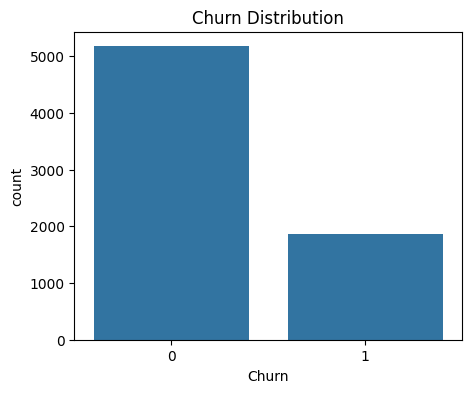

In [15]:

plot_churn_distribution(df)


In [16]:

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)
X = df_enc.drop('Churn', axis=1)
y = df_enc['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:

log_model = train_logistic_regression(X_train_scaled, y_train)
rf_model = train_random_forest(X_train, y_train)


print('Logistic Regression:')
print(evaluate_model(log_model, X_test_scaled, y_test))
print('\nRandom Forest:')
print(evaluate_model(rf_model, X_test, y_test))


os.makedirs('models', exist_ok=True)
save_model(rf_model, 'models/rf_model.joblib')
save_model(log_model, 'models/log_model.joblib')


Logistic Regression:
{'accuracy': 0.8069552874378992, 'report': {'0': {'precision': 0.8509659613615456, 'recall': 0.893719806763285, 'f1-score': 0.8718190386427899, 'support': 1035.0}, '1': {'precision': 0.6583850931677019, 'recall': 0.5668449197860963, 'f1-score': 0.6091954022988506, 'support': 374.0}, 'accuracy': 0.8069552874378992, 'macro avg': {'precision': 0.7546755272646237, 'recall': 0.7302823632746906, 'f1-score': 0.7405072204708203, 'support': 1409.0}, 'weighted avg': {'precision': 0.7998479736365651, 'recall': 0.8069552874378992, 'f1-score': 0.8021091451064993, 'support': 1409.0}}, 'roc_auc': 0.8415846443979436}

Random Forest:
{'accuracy': 0.7899219304471257, 'report': {'0': {'precision': 0.8307967770814683, 'recall': 0.8966183574879227, 'f1-score': 0.862453531598513, 'support': 1035.0}, '1': {'precision': 0.6335616438356164, 'recall': 0.4946524064171123, 'f1-score': 0.5555555555555556, 'support': 374.0}, 'accuracy': 0.7899219304471257, 'macro avg': {'precision': 0.732179210

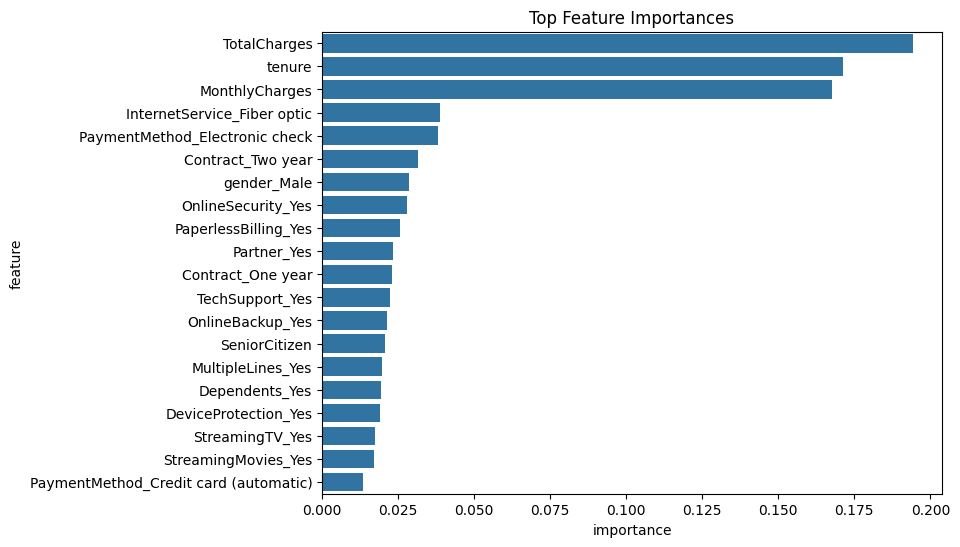

In [18]:

try:
    import numpy as np
    feats = X.columns.tolist()
    imps = rf_model.feature_importances_
    plot_feature_importance(feats, imps, top_n=20, save_path='models/feature_importance.png')
except Exception as e:
    print('Could not plot feature importance.', e)


## Conclusion
- This notebook provides a baseline churn prediction pipeline. Improve by hyperparameter tuning, feature engineering, and using cross-validation.